### Tuning Machine Learning Models Using the Caret R Package
+ http://weather.gladstonefamily.net/site/24763
+ http://climatebase.ru/station/24763/60_80
+ https://www.datacamp.com/courses/cleaning-data-in-r

In [101]:
# http://stackoverflow.com/questions/18695335/replacing-all-nas-with-smoothing-spline
# https://www.rdocumentation.org/packages/zoo/versions/1.7-14/topics/na.approx
require(zoo)
z <- zoo(c(2, NA, 1, 4, 5, 2), c(1, 3, 4, 6, 7, 8))
str(z)
z
## use underlying time scale for interpolation
na.approx(z) 
## use equidistant spacing
na.approx(z, 1:6)

'zoo' series from 1 to 8
  Data: num [1:6] 2 NA 1 4 5 2
  Index:  num [1:6] 1 3 4 6 7 8


 1  3  4  6  7  8 
 2 NA  1  4  5  2 

       1        3        4        6        7        8 
2.000000 1.333333 1.000000 4.000000 5.000000 2.000000 

  1   3   4   6   7   8 
2.0 1.5 1.0 4.0 5.0 2.0 

In [97]:
filled_path <- "C:/Users/IVA/Dropbox/Apps/R/"
setwd(filled_path); getwd()
cli_dataset <-read.table("1967.cli", header=FALSE, sep="")
names(cli_dataset) <- c("day", "month", "year", "prec", "temp");
cli_dataset[cli_dataset$prec == -9999, 4] <- NA # vector <- cli_dataset[, 4];
cli_dataset[cli_dataset$temp == -9999, 5] <- NA ; vector <- cli_dataset[, 5]; 
str(vector)
days <- dim(cli_dataset)[1]
mean(vector, na.spline=T)

[1] "C:/Users/IVA/Dropbox/Apps/R"

 int [1:365] -486 -515 -466 NA -481 -527 -522 -472 NA NA ...


[1] NA

In [95]:
cli_dataset[!complete.cases(cli_dataset),]
vector[!complete.cases(vector)]

,day,month,year,prec,temp
4,4,1,1967,NA,NA
9,9,1,1967,NA,NA
10,10,1,1967,NA,NA
12,12,1,1967,NA,NA
13,13,1,1967,NA,NA
14,14,1,1967,NA,NA
16,16,1,1967,NA,NA
17,17,1,1967,NA,NA
24,24,1,1967,NA,NA
27,27,1,1967,NA,NA


ERROR: Error in vector[!complete.cases(vector), ]: неправильное количество измерений


In [90]:
#Load Packages
require(quantmod) #for Lag()
require(nnet)
require(neuralnet)
library(plyr) 
require(caret)

#Make toy dataset
max((vector), na.rm = T)
y <- vector / max((vector), na.rm = T)
str(y)
summary(y)
y <- na.omit(y)
te <- data.frame(y, x1=Lag(y,1), x2=Lag(y,2), x3=Lag(y,3))
names(te) <- c("y", "x1", "x2", "x3")

summary(te)

[1] 251

 num [1:365] -1.94 -2.05 -1.86 NA -1.92 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-2.1590 -1.3800 -0.1534 -0.4380  0.4183  1.0000      33 

       y                 x1                x2                x3         
 Min.   :-2.1594   Min.   :-2.1594   Min.   :-2.1594   Min.   :-2.1594  
 1st Qu.:-1.3805   1st Qu.:-1.3725   1st Qu.:-1.3616   1st Qu.:-1.3466  
 Median :-0.1534   Median :-0.1474   Median :-0.1375   Median :-0.1275  
 Mean   :-0.4380   Mean   :-0.4331   Mean   :-0.4281   Mean   :-0.4229  
 3rd Qu.: 0.4183   3rd Qu.: 0.4183   3rd Qu.: 0.4183   3rd Qu.: 0.4183  
 Max.   : 1.0000   Max.   : 1.0000   Max.   : 1.0000   Max.   : 1.0000  
                   NA's   :1         NA's   :2         NA's   :3        

In [91]:
my.grid <- expand.grid(.size=c(1,5,10), .decay=c(0, 0.01, 0.001))
str(my.grid)

'data.frame':	9 obs. of  2 variables:
 $ .size : num  1 5 10 1 5 10 1 5 10
 $ .decay: num  0 0 0 0.01 0.01 0.01 0.001 0.001 0.001
 - attr(*, "out.attrs")=List of 2
  ..$ dim     : Named int  3 3
  .. ..- attr(*, "names")= chr  ".size" ".decay"
  ..$ dimnames:List of 2
  .. ..$ .size : chr  ".size= 1" ".size= 5" ".size=10"
  .. ..$ .decay: chr  ".decay=0.000" ".decay=0.010" ".decay=0.001"


In [92]:
#Fit model
start.time <- Sys.time()
model <- train(y ~ x1 + x2 + x3, te, method='nnet', linout=TRUE, trace = FALSE, na.action = na.omit , # preProcess="scale",
                #Grid of tuning parameters to try:
                tuneGrid=expand.grid(.size=c(1,5,10), .decay=c(0, 0.01, 0.001))) 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken
#Time difference of 54.70013 secs Core2Duo

Time difference of 22.46404 secs

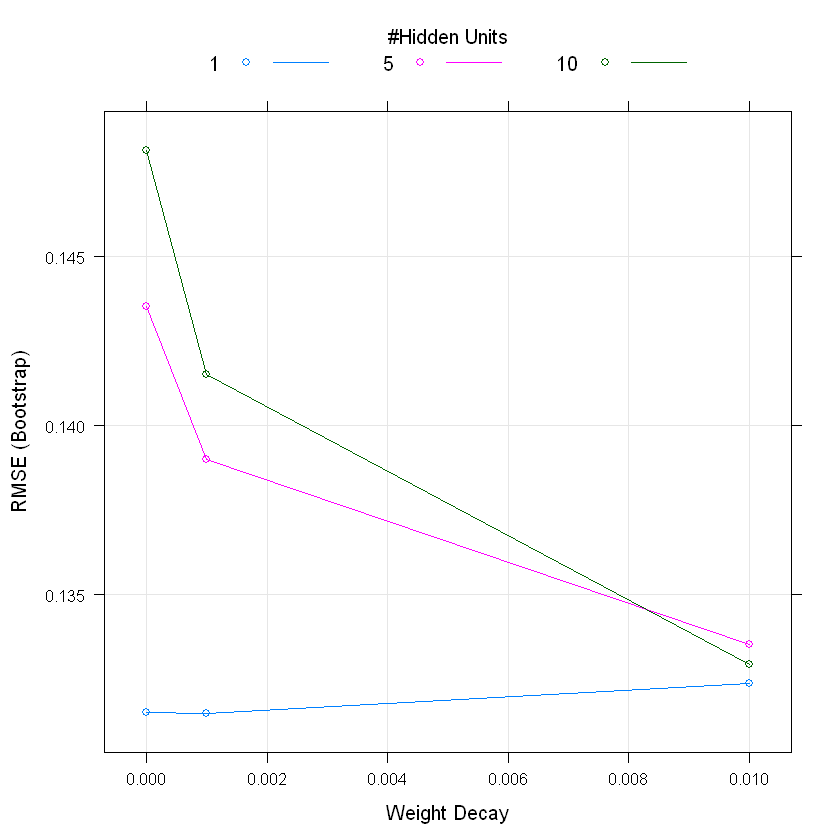

In [84]:
plot(model)

4,-1.826425
8,-1.979065
9,-1.850976
21,-1.847547
22,-1.546357
23,-1.668114
24,-1.821591
34,-1.871358
35,-1.946910
36,-1.754102
37,-1.779441


Neural Network 

264 samples
  3 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 264, 264, 264, 264, 264, 264, ... 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
   1    0.000  0.1315017  0.9785292
   1    0.001  0.1314861  0.9785159
   1    0.010  0.1323646  0.9781916
   5    0.000  0.1435350  0.9745037
   5    0.001  0.1390085  0.9760499
   5    0.010  0.1335267  0.9778773
  10    0.000  0.1481407  0.9727126
  10    0.001  0.1415046  0.9752101
  10    0.010  0.1329420  0.9780638

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 1 and decay = 0.001. 

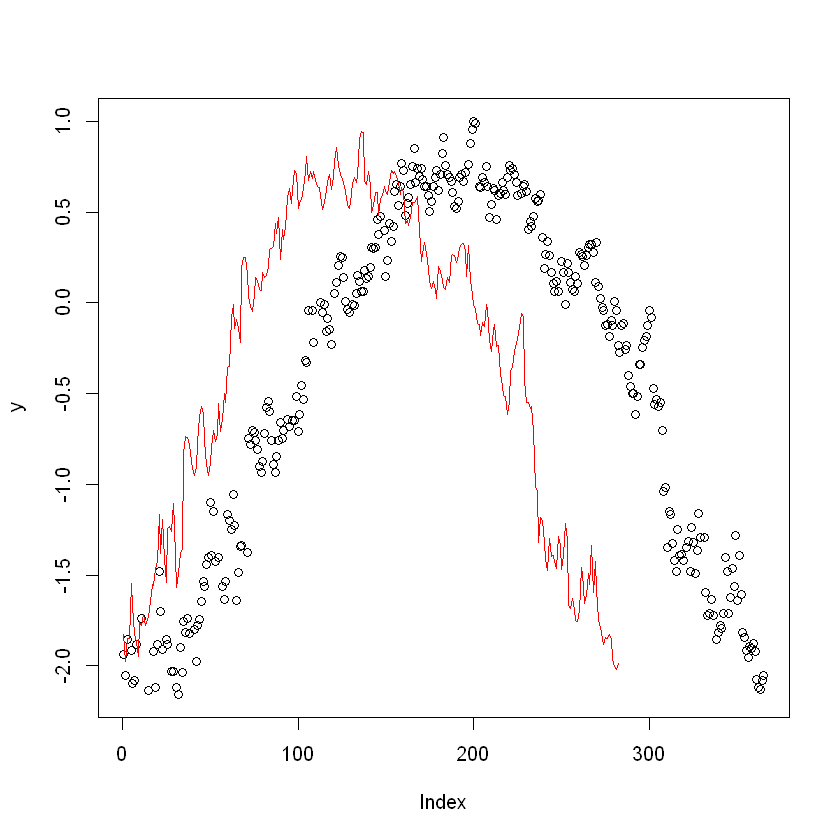

In [88]:
ps <- predict(model, te)
ps
#Examine results
model
plot(y)
lines(ps, col=2)

In [ ]:
te <- data.frame(y, x1=Lag(y,3), x2=Lag(y,1), x3=Lag(y,2))
ps <- predict(model, days)

#Examine results
model
plot(y)
lines(ps, col=2)

In [80]:
vector <- cli_dataset[, 4];
str(vector)


 int [1:365] 0 0 0 NA 4 0 0 2 NA NA ...


+ https://topepo.github.io/caret/train-models-by-tag.html#Neural_Network
+ http://stats.stackexchange.com/questions/21717/how-to-train-and-validate-a-neural-network-model-in-r
+ http://topepo.github.io/caret/model-training-and-tuning.html
+ https://datascienceplus.com/fitting-neural-network-in-r/
+ http://www.statmethods.net/input/missingdata.html
